In [3]:
from google.colab import drive #Google drive 접근 권한 할당
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls /content/drive/MyDrive/custom_data/ #압축파일

car.zip  model.pth  test  train


In [9]:
!unzip  /content/drive/MyDrive/custom_data/car.zip -d /content/drive/MyDrive/custom_data #압축파일 푸는 명령 코드

Archive:  /content/drive/MyDrive/custom_data/car.zip
replace /content/drive/MyDrive/custom_data/test/Convertible/convertible_0_09062020_145449.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
import numpy as np #넘피
import torchvision.datasets as datasets #datasets 함수 라이브러리
import torchvision.transforms as transforms #transforms 함수 라이브러리
import torch # 토치 라이브러리
import time # 시간측정 라이브러리
import torchvision #이미지 및 영상 변환을 위한 유틸리티 / 사전 학습된 데이터 세트 일부를 가진 torchvision 라이브러리
start = time.time() # 시작 시간 저장

from torch.utils.data import Dataset, DataLoader #Dataset을 쓰기 위해 Dataset을 상속받아야 하니 Dataset을 받아와라.
                                                 #DataLoader를 이용하려면 data를 보관하고 있는 class인 Dataset 형의 calss가 필요하다.


trainset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/custom_data/train", #trainset 데이터 불러오는 코드
                                            transform = transforms.ToTensor())

testset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/custom_data/test", #testset 데이터 불러오는 코드
                                            transform = transforms.ToTensor())

print(trainset.classes, testset.classes) # trainset, testset 클래스
print(len(trainset), len(testset)) # trainset, testset 개수

['Convertible', 'Coupe', 'Hatchback', 'Pickup', 'SUV', 'Sedan'] ['Convertible', 'Coupe', 'Hatchback', 'Pickup', 'SUV', 'Sedan']
6969 1482


In [ ]:
import numpy as np #넘피
import torchvision.datasets as datasets #datasets 함수 라이브러리
import torchvision.transforms as transforms #transforms 함수 라이브러리
import torchvision.models as models #datasets 함수 라이브러리
import torch.nn as nn #nn 함수르 라이브러리
import torch.nn.functional as F #nn.functional 함수 라이브러리
import torch.optim as optim #optim 함수 라이브러리
from torchvision import models #학습된 VGGNet을 불러온다
import torchvision # 토치버전 라이브러리
import torch # 토치 라이브러리
from torch.utils.data import Dataset, DataLoader #Dataset을 쓰기 위해 Dataset을 상속받아야 하니 Dataset을 받아와라.
                                                 #DataLoader를 이용하려면 data를 보관하고 있는 class인 Dataset 형의 calss가 필요하다.

device = 'cuda' if torch.cuda.is_available() else 'cpu' #devicer가 GPU를 사용할 수 있는 환경이면 Cuda, 아니면 Cpu

transform = transforms.Compose( #Transfer learning 구현
    [transforms.Resize((224,224)), #VGGNet 244*224 크기 변환
     transforms.ToTensor(), #Tensor 형태로 변환 
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]) # 정규분포, (평균 / 표준편차)

trainset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/custom_data/train", #root에t custom_data/train 저장폴더 객체선언
                                            transform = transform)

testset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/custom_data/test", #root에t custom_data/test 저장폴더 객체선언
                                            transform = transform)

print(len(trainset), len(testset)) #총 데이터 수

batch_size = 32  #배치크기 = 32

train_loader = torch.utils.data.DataLoader(dataset=trainset, #dataset에 내가 만든 객체이름 넣어주기
                                           batch_size=batch_size, #배치 크기 코드
                                           shuffle=True, #섞는 코드
                                           num_workers = 0) 

test_loader = torch.utils.data.DataLoader(dataset=testset, #dataset에 내가 만든 객체이름 넣어주기
                                           batch_size=batch_size, #배치 크기 코드
                                           shuffle=False, #섞지 않는 코드
                                          num_workers = 0) 

net = models.vgg16(pretrained=True) #사전 학습된 VGGNet 불러오기
net.classifier[6] = nn.Linear(4096,6) #FC layer 최종 출력이 6(클래스의 수)인 linear model 생성
net.to(device) # cuda

# method 2
for param in net.features.parameters(): #convolutional layers 학습 하지 않는 코드
  param.requires_grad = False #gradient 학습x

criterion = torch.nn.CrossEntropyLoss() #CrossEntropyLoss 구현하는 객체 criterion
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum = 0.9) #SGD를 구현 하는 객체 optimizer
 

def train(epoch): #train하는 함수 
  net.train()
  for batch_idx, (x, y) in enumerate(train_loader): #train_loader 배치 데이터 받아옴
    x, y = x.to(device), y.to(device) #model에 입력되는 x,y 데이터를 GPU에 복사한다
    optimizer.zero_grad() #객체 초기화
    yhat = net(x) #출력결과 예측하는 코드
    loss = criterion(yhat,y) #loss 계산
    loss.backward() #backward 계산
    optimizer.step() #파라미터 업데이트
    
    if batch_idx % 10 == 0: #배치 10번째마다 현재 로스값 출력
      print(f'Tran Epoch: {epoch}',
            f'[{batch_idx * len(x)}/{len(train_loader.dataset)} ({batch_idx/len(train_loader)*100:0.2f}%)]', #몇번째 데이터 학습을 하였는지 알 수 있는 코드
            f'\tLoss: {loss.item():0.6f}') #loss 계산값 출력                                                 #얼마만큼 학습을 했는지 알 수 있다

def test(): #test하는 함수
  net.eval()
  correct = 0
  for x, y in test_loader: #test_loader 데이터 받아옴
    x, y = x.to(device), y.to(device) #model에 입력되는 x,y 데이터를 GPU에 복사한다
    yhat = net(x) #출력결과 예측하는 코드
    pred = torch.max(yhat,1)[1] #최고값 있는 클래스 index값
    correct += pred.eq(y.data.view_as(pred)).sum() #corret는 에측값 정답값 중 정답을 맞춘 논리 값 개수 더해주는 코드
  print(f'\nTest Accuracy: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset)*100:0.2f}%)\n') #맞춘개수 확률을 알 수 있다.       

 
for epoch in range(10): #배치 10번째마다 반복
  train(epoch) 
  test()   #test 출력

torch.save(net,'/content/drive/MyDrive/custom_data/model.pth') #Weight 파일 저장 / 학습 완료 모델 저장

6969 1482
Tran Epoch: 0 [0/6969 (0.00%)] 	Loss: 1.915117


In [139]:
net = torch.load('/content/drive/MyDrive/custom_data/model.pth') #Weight 파일 불러오기 / 학습 완료된 모델 불러오기

Answer = SUV
Predict =  Hatchback


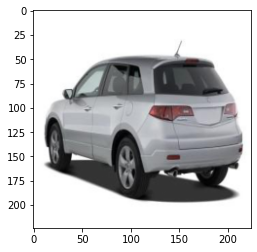

In [136]:
import matplotlib.pyplot as plt #matplotlib
import numpy as np #넘피

def mat_imshow(img, one=False):
  if one:
    img = img.mean(dim=0) # unnormalize
  img = img / 2 + 0.5
  npimg = img.numpy()
  if one:
    plt.imshow(npimg, cmap="Greys") #그림 명령 코드
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

test_index = 1380 # 1380번째 이미지
classes = ('Convertible', 'Coupe', 'Hatchback', 'Pickup', 'SUV', 'Sedan') # class 종류
print('Answer =', classes[testset[test_index][1]]) #1380번째 정답 이미지 데이터
mat_imshow(testset[test_index][0])   

with torch.no_grad():
  net.eval()
  x = testset[test_index][0].view(1,3,224,224).to(device) #1380번째 예측 이미지 x 데이터
  yhat = net(x)
  print('Predict = ', classes[torch.max(yhat,1)[1]]) #Predict = 최고값 있는 클래스 index값